In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
import PIL.Image
from tensorflow.keras import layers
import os
import IPython.display as display
import time
import pathlib
import glob
import imageio

In [5]:
# List available GPUs
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Set path to the dataset
data_dir = pathlib.Path('./dataset/')

In [ ]:
# Image count
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

63565


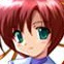

In [ ]:
images = list(data_dir.glob('*/*.jpg'))
PIL.Image.open(images[1]).resize((64, 64))

In [ ]:
# Variables
batch_size = 256
buffer_size = 1000
image_size = (64, 64)
epochs = 200
noise_dim = 100
num_examples_to_generate = 16

In [ ]:
train_images = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode=None,
    image_size= image_size,
    batch_size=batch_size)

Found 63565 files belonging to 1 classes.


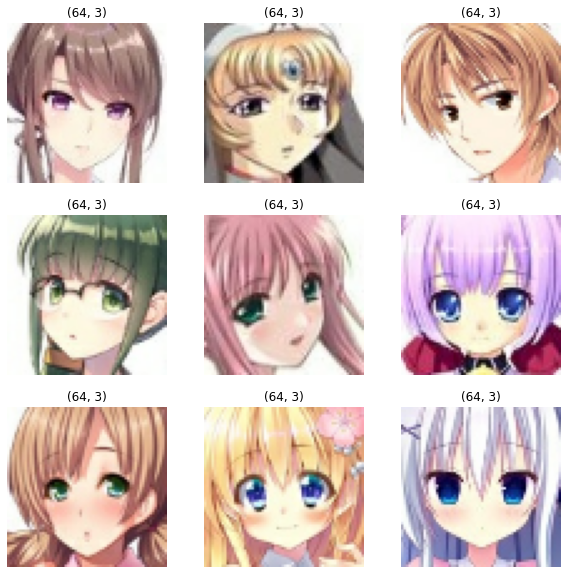

In [ ]:
plt.figure(figsize=(10, 10))
for images in train_images.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    a = images[i].numpy().astype('uint8')
    a = a.reshape((64, 64, 3))
    plt.title(images[0][i].numpy().shape)
    plt.imshow(a)
    plt.axis("off")

In [ ]:
# Changing channel range from [0, 255] to [0, 1]
train_dataset = train_images.map(lambda x: x / 255.0)

In [6]:
# Generator
def getGenerator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=1, padding='same',))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same',))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same',))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same',))
    model.add(layers.Activation('tanh'))
    assert model.output_shape == (None, 64, 64, 3)
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        1048832   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


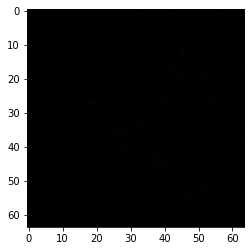

In [7]:
noise = tf.random.normal([1, 100])
generator = getGenerator()
print(generator.summary())
generated_image = generator(noise, training=False)
generator.predict(noise)

plt.imshow(generated_image[0])

In [ ]:
generator.output_shape

(None, 64, 64, 3)

In [8]:
# Discriminator
discriminator = tf.keras.Sequential([
    layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=[64, 64, 3]),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(128, kernel_size=5, strides=2, padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(128, kernel_size=5, strides=2, padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(256, kernel_size=5, strides=2, padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1),
    layers.Activation('sigmoid')
])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49991158]], shape=(1, 1), dtype=float32)


In [9]:
# We are using Binary Cross Entropy loss since the discriminator is a binary classifier
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
def discriminator_loss(real_output, fake_output):
    # We want discriminator to output 1 for real images and 0 for generated images
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    # Generator wants discriminator to output 1
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

In [11]:
# We are saving the generator and discriminator models so that they can be loaded later for further training or testing
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)


In [ ]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return disc_loss, gen_loss
    

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    disc_loss = []
    gen_loss = []
    for image_batch in dataset:
      x,y = train_step(image_batch)
      disc_loss.append(x)
      gen_loss.append(y)
    disc_loss = np.mean(disc_loss)
    gen_loss = np.mean(gen_loss)
    
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epoch + 1,
                            seed)

    s = 'Time for epoch {} is {} sec / g_loss: {:.3f}, d_loss: {:.3f}'.format(
      epoch + 1, time.time()-start, gen_loss, disc_loss)
    print(s)
    with open('log.txt', 'a') as f:
      f.write(s + '\n')
      f.close()
    

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

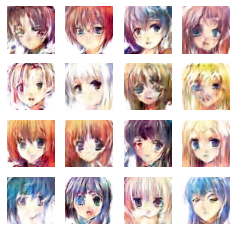

In [ ]:
train(train_dataset, epochs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

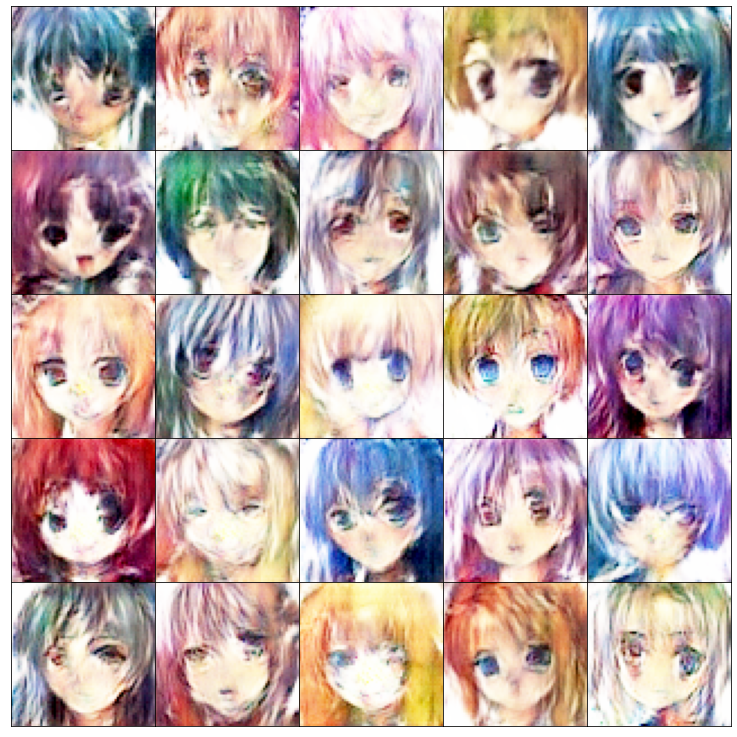

In [ ]:
final = generator(tf.random.normal([25, noise_dim]))
fig = plt.figure(figsize=(10, 10))
#disable left and bottom axis
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(final[i])

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)